# **Time Series Analysis using ARIMA**

### **Importing the libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### **Loading the dataset**

In [4]:
data = pd.read_csv("/content/time series data.csv")
data.head()

,utc_timestamp,IT_load_new,IT_solar_generation
0,2016-01-01T00:00:00Z,21665.0,1
1,2016-01-01T01:00:00Z,20260.0,0
2,2016-01-01T02:00:00Z,19056.0,0
3,2016-01-01T03:00:00Z,18407.0,0
4,2016-01-01T04:00:00Z,18425.0,0


### **Data Visualization**

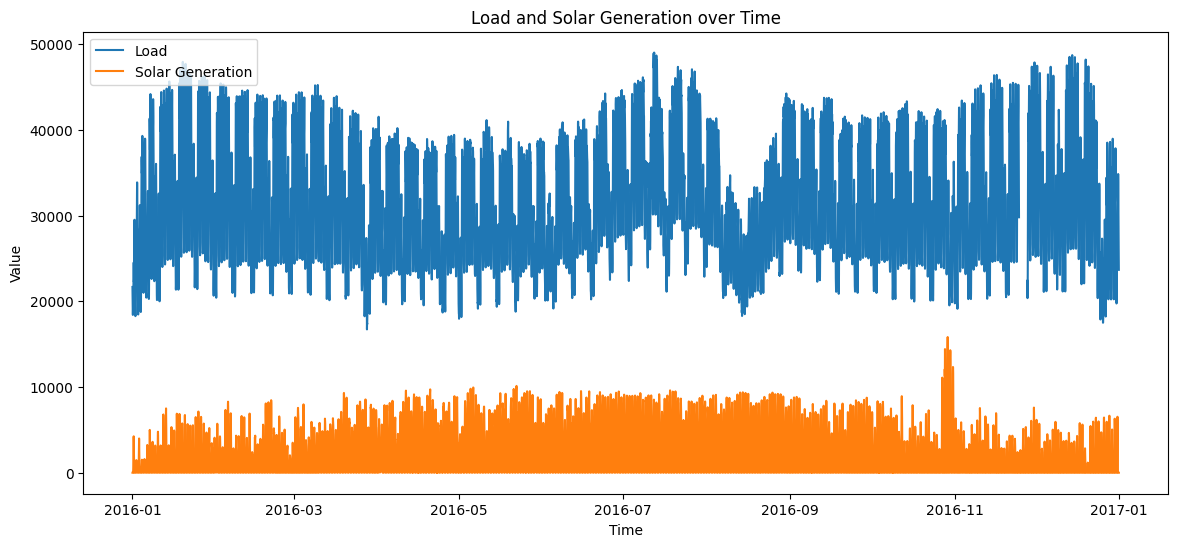

In [5]:
data["utc_timestamp"] = pd.to_datetime(data["utc_timestamp"])

plt.figure(figsize = (14,6))
plt.plot(data["utc_timestamp"], data['IT_load_new'], label="Load")
plt.plot(data["utc_timestamp"], data['IT_solar_generation'], label="Solar Generation")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("Load and Solar Generation over Time")
plt.show()

### **Missing Values**

In [6]:
data.isnull().sum()

,0
utc_timestamp,0
IT_load_new,72
IT_solar_generation,0


In [7]:
# filling the missing value with last valid value
data["IT_load_new"].fillna(method = "ffill", inplace = True)

/tmp/ipython-input-7-1134398708.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["IT_load_new"].fillna(method = "ffill", inplace = True)
/tmp/ipython-input-7-1134398708.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["IT_load_new"].fillna(method = "ffill", inplace = True)


In [8]:
print("Missing values after filling:")
print(data.isnull().sum())

Missing values after filling:
utc_timestamp          0
IT_load_new            0
IT_solar_generation    0
dtype: int64


### **Augumented Dickey Fuller Test**

In [9]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
  print("Results of Dickey Fuller Test:")
  dftest = adfuller(timeseries, autolag = "AIC")
  dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)

In [10]:
print("ADF test for 'IT_load_new':")
adf_test(data['IT_load_new'])

ADF test for 'IT_load_new':
Results of Dickey Fuller Test:
Test Statistic                -1.197390e+01
p-value                        3.841445e-22
#Lags Used                     3.700000e+01
Number of Observations Used    8.746000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


In [11]:
print("ADF test for 'IT_solar_generation':")
adf_test(data['IT_solar_generation'])

ADF test for 'IT_solar_generation':
Results of Dickey Fuller Test:
Test Statistic                -5.741335e+00
p-value                        6.265438e-07
#Lags Used                     3.600000e+01
Number of Observations Used    8.747000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861870e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


As p values are less than 0.05 for both load and solar values we reject the null hypothesis (The time series is non stationary). So we conclude that the time series data is stationary and we can apply the ARIMA model.

### **ACF and PACF for Load**

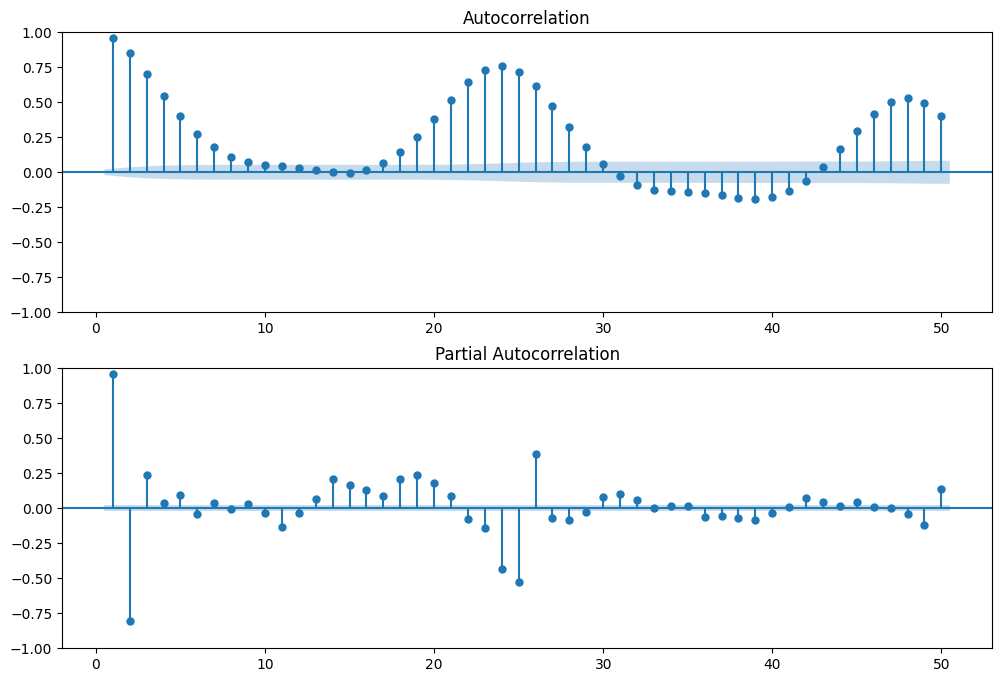

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1,ax2) = plt.subplots(2,1, figsize = (12,8))
plot_acf(data['IT_load_new'], lags =50, zero = False, ax = ax1)
plot_pacf(data['IT_load_new'], lags =50, zero = False, ax = ax2)
plt.show()

In the ACF plot there is a gradual decrease while in PACF graph there is a sharp decrease after lag 2 so we take p = 2 and q = 2.

### **Fitting ARIMA model**

#### **Using d = 0**

In [14]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [15]:
# splitting the dataset
train_size = int(len(data) * 0.8)
train, test = data['IT_load_new'][:train_size], data['IT_load_new'][train_size:]

In [19]:
# fitting the model
model = ARIMA(train, order = (2,0,2))
model_fit = model.fit()

In [20]:
# making predictions
predictions = model_fit.predict(start = len(train), end = len(train) + len(test) - 1)

In [21]:
# RMSE
rmse = sqrt(mean_squared_error(test, predictions))
rmse

7714.95213482925

#### **Using d = 1**

In [26]:
# fitting the model
model = ARIMA(train, order = (2,1,2))
model_fit = model.fit()

In [27]:
# making predictions
predictions = model_fit.predict(start = len(train), end = len(train) + len(test) - 1)

In [28]:
# RMSE
rmse = sqrt(mean_squared_error(test, predictions))
rmse

7993.84942771682

### **Plotting actual vs predicted values**

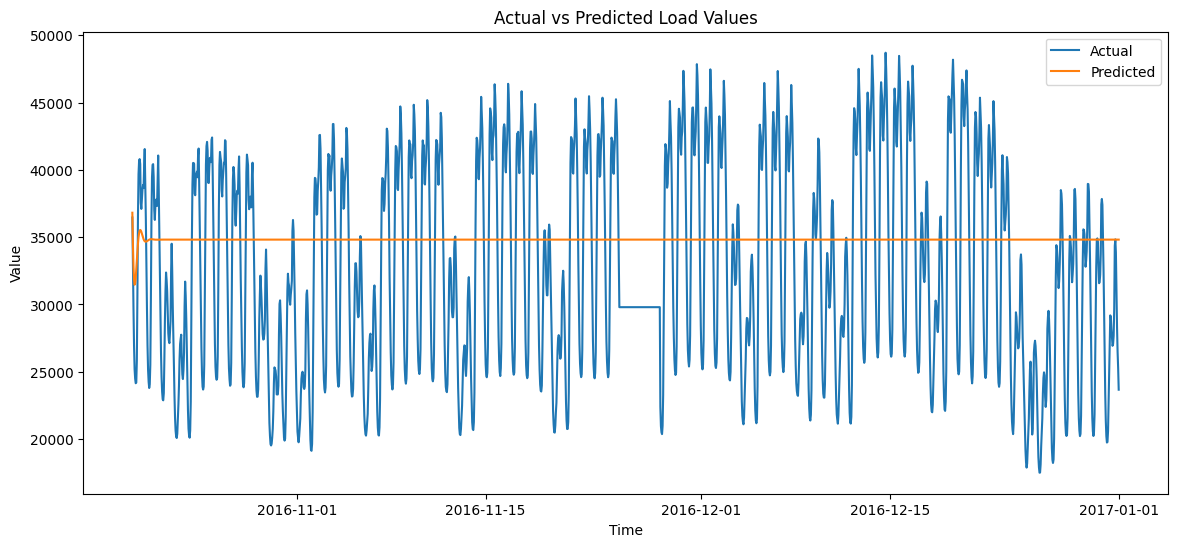

In [29]:
plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'][train_size:], test, label='Actual')
plt.plot(data['utc_timestamp'][train_size:], predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Load Values')
plt.show()

### **ACF and PACF for Solar Generation**

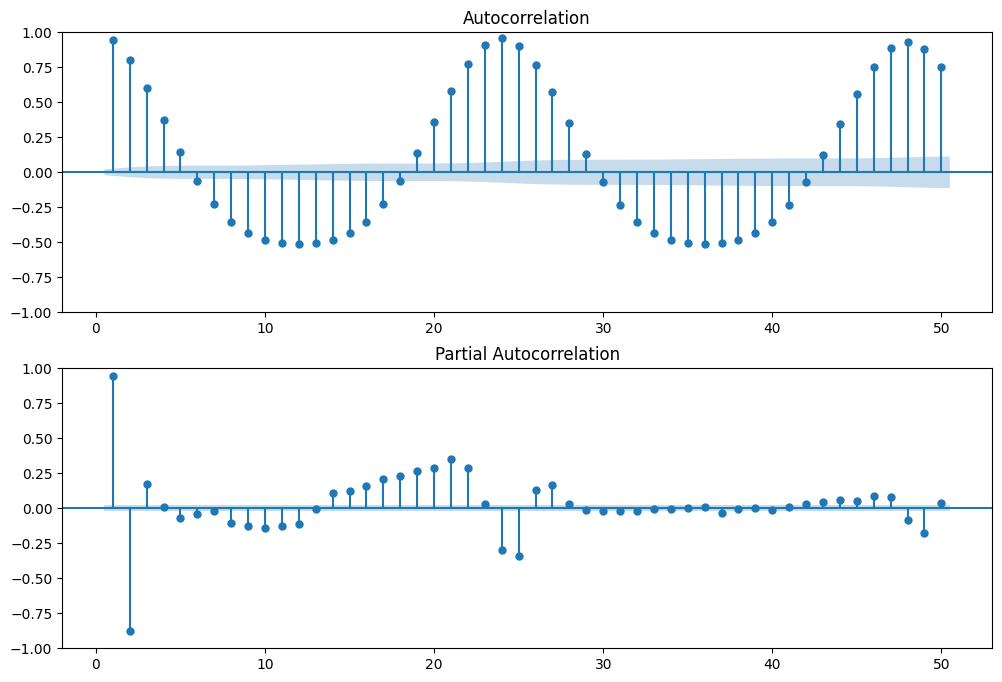

In [30]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(data['IT_solar_generation'], lags=50, zero=False, ax=ax1)
plot_pacf(data['IT_solar_generation'], lags=50, zero=False, ax=ax2)
plt.show()

### **Fitting ARIMA model**

In [31]:
# splitting the dataset
train_size = int(len(data['IT_solar_generation']) * 0.8)
train, test = data['IT_solar_generation'][:train_size], data['IT_solar_generation'][train_size:]

In [32]:
# fitting the model
model = ARIMA(train, order = (2,0,2))
model_fit = model.fit()

In [33]:
# making predictions
predictions = model_fit.predict(start = len(train), end = len(train) + len(test) - 1)

In [34]:
# RMSE
rmse = sqrt(mean_squared_error(test, predictions))
rmse

2486.1507110911857

### **Plotting actual vs predicted values**

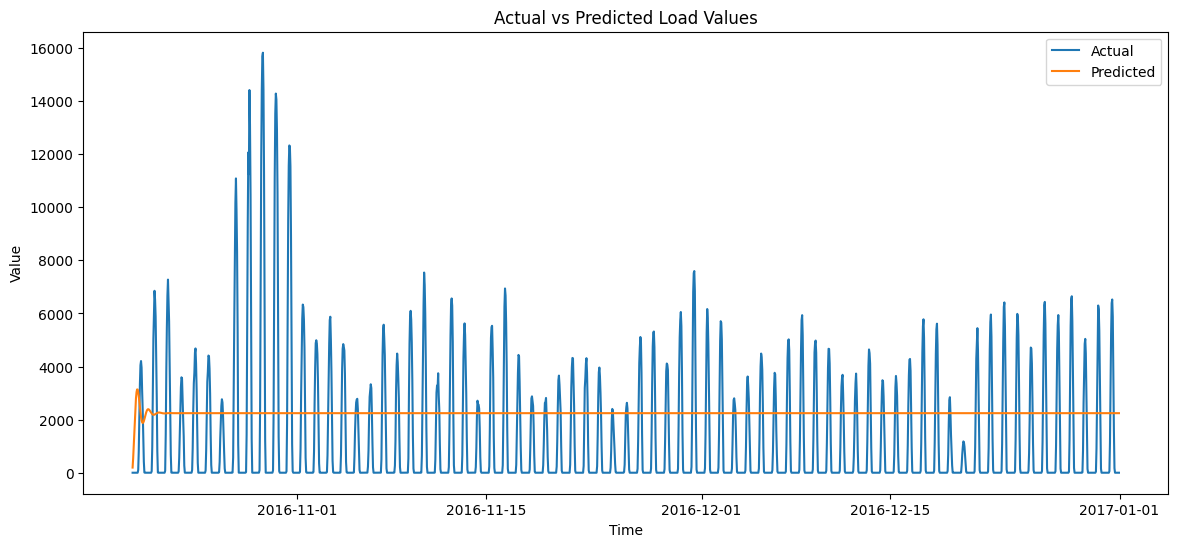

In [35]:
plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'][train_size:], test, label='Actual')
plt.plot(data['utc_timestamp'][train_size:], predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Load Values')
plt.show()